In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils

torch.manual_seed(3);

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, n_e):
        super().__init__()
        self.e = 1e-20
        self.g = nn.Parameter(torch.ones(n_e))
        self.b = nn.Parameter(torch.zeros(n_e))
    
    def forward(self, X):
        mu = X.mean(dim=-1, keepdims=True)
        v = X.var(dim=-1, keepdims=True)
        X = (X - mu) / (torch.sqrt(v) + self.e)
        return self.g * X + self.b

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, n_e, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_e, 4 * n_e),
            nn.GELU(),
            nn.Linear(4 * n_e, n_e),
            nn.Dropout(d),
        )

    def forward(self, X):
        return self.net(X)

In [ ]:
class Head(nn.Module):

    def __init__(self, n_e, sz):
        super().__init__()
        self.sz = sz
        self.q = nn.Linear(n_e, sz)
        self.k = nn.Linear(n_e, sz)
        self.v = nn.Linear(n_e, sz)
    
    def forward(self, X):
        Q = self.q(X)
        K = self.k(X)
        V = self.v(X)

        scaled_dot = Q @ torch.transpose(K, -1, -2) / self.sz ** 0.5
        AZ = scaled_dot.masked_fill(torch.tril(scaled_dot) == 0, float('-inf'))
        return F.softmax(AZ, dim=-1) @ V

In [ ]:
class MHA(nn.Module):

    def __init__(self, n_e, n_h):
        super().__init__()
        sz = n_e // n_h
        self.h = nn.ModuleList([Head(n_e, sz) for _ in range(n_h)])
        self.W_o = nn.Linear(sz * n_h, n_e)
    
    def forward(self, X):
        o = torch.cat([h(X) for h in self.h], dim=-1)
        return self.W_o(o)

In [ ]:
class Block(nn.Module):

    def __init__(self, n_e, n_h, d):
        super().__init__()
        self.norm_z = LayerNorm(n_e)
        self.mha = MHA(n_e, n_h)
        self.norm_a = LayerNorm(n_e)
        self.mlp = FeedForward(n_e, d)
    
    def forward(self, x):
        x = self.mha(self.norm_z(x))
        x = self.mlp(self.norm_a(x))
        return x

In [ ]:
class GPTModel(nn.Module):

    def __init__(self, conf):
        super().__init__()
        self.n_e, self.n_h, self.n_l, self.n_c, self.n_v, self.n_h, self.d = conf.n_e, conf.n_h, conf.n_l, conf.n_c, conf.n_v, conf.n_h, conf.d
        self.E = nn.Embedding(self.n_v, self.n_e)
        self.P = nn.Embedding(self.n_c, self.n_e)
        self.layers = nn.Sequential(*[Block(self.n_e, self.n_h, self.d) for _ in range(self.n_l)])
        self.normalize_o = LayerNorm(self.n_e)
        self.mlp = nn.Linear(self.n_e, self.n_v)
        self.apply(self.w_and_b)

    def w_and_b(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        if isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def number_of_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, x, y=None):
        T = len(x)
        e = self.E(x) + self.P(torch.arange(T))

        a = self.layers(e)
        Z =  self.mlp(self.normalize_o(a))
        B, T, C = Z.shape

        if y is not None:
            y = y.view(B*T)
            Z = Z.view(B*T, C)
            loss = F.cross_entropy(Z, y)
        else:
            loss = None
        return Z, loss

    def create(self, p, max_new_tokens):
        """ p -- a prompt-like """
        for _ in range(max_new_tokens):
            p = p[:, - self.n_c:]
            Z, loss = self(p)
            Z = Z[:, -1, :]
            probs = F.softmax(Z, dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            
            p = torch.cat((p, new_token), dim=1)

        return p

In [ ]:
from dataclasses import dataclass

@dataclass
class GPT_conf:
    n_c: int = 8
    n_e: int = 8
    n_h: int = 4
    n_l: int = 6
    n_v: int = 27
    d: float = 0.2
    batch_size: int = 8

In [ ]:
conf = GPT_conf()
model = GPTModel(conf)
print(f'Number of parameters = {model.number_of_parameters():,}')

lr = 3e-4
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

L = []

batch_loader = utils.load_batch()

for b in range(10_000):
    break
    Z, loss = model(X, Y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    l = loss.item()
    if b % 1000 == 0:
        print(l)
    L.append(l) 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
import random

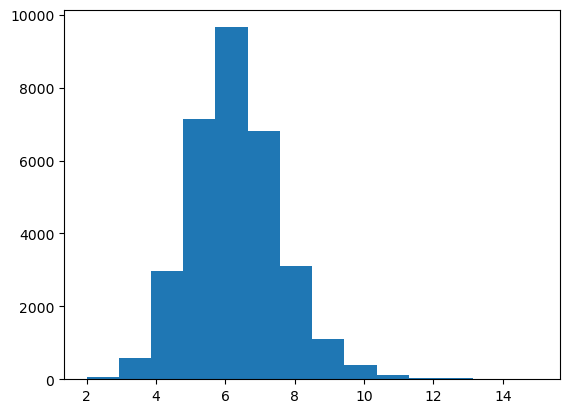

In [3]:
d = open('names.txt', 'r').readlines()

s = np.array([len(n) for n in d])-1
plt.hist(s, bins=14);

In [4]:
samples = [random.choice(d) for _ in range(10)]
pp(samples)

['jaskirat\n',
 'kalliope\n',
 'ovadia\n',
 'leonor\n',
 'javiah\n',
 'audrianna\n',
 'hazyl\n',
 'jayvon\n',
 'tylasia\n',
 'caily\n']


In [5]:
u = len(d)
v = len(list(set(d)))
f = u - v
print(u, v, f)

32033 29494 2539


In [6]:
lengths = [len(n) for n in d]
n = len(lengths)
mu = sum(lengths) / n
f = ((np.array(lengths)-mu)**2).sum()
s = np.sqrt(f/n)
print(round(mu, 0), round(s, 0))

7.0 1.0


In [7]:
trash = [n for n in d if len(n) > 9]
print(f'Number of long words = {len(trash):,}')
samples = [random.choice(trash).strip() for _ in range(10)]
for m in samples:
    print(m)

Number of long words = 1,693
christoph
sabastian
jamielynn
magdaleno
keerthana
angellina
milagrace
jullianna
johnlucas
chantelle


In [8]:
v = sorted(list(set(''.join(d))))
print(len(v), v)

27 ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
20,859

In [2]:
from model import GPTModel, GPT_conf
from pprint import pprint as pp

conf = GPT_conf()
print(conf)
model = GPTModel(conf)
print(f'{model.number_of_parameters():,}')
pp(model)

GPT_conf(n_c=16, n_e=32, n_h=4, n_l=4, n_v=27, d=0.1, batch_size=8)
53,147
GPTModel(
  (E): Embedding(27, 32)
  (P): Embedding(16, 32)
  (layers): Sequential(
    (0): Block(
      (norm_z): LayerNorm()
      (mha): MHA(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (q): Linear(in_features=32, out_features=8, bias=True)
            (k): Linear(in_features=32, out_features=8, bias=True)
            (v): Linear(in_features=32, out_features=8, bias=True)
          )
        )
        (W_o): Linear(in_features=32, out_features=32, bias=True)
      )
      (norm_a): LayerNorm()
      (mlp): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=32, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Block(
      (norm_z): LayerNorm()
      (mha): 

In [8]:
from utils import prepare, load_batch, run, encode
import random